In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import itertools

from scipy import stats
import rbo

import utils

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

plt.rcParams["figure.figsize"] = (22,12)

font = {'size'   : 22}
matplotlib.rc('font', **font)

# Utility Functions

In [2]:
def calculate_measures(df, measure, num_true_homographs):
    '''
    Calculates and adds columns precision_`measure`, recall_`measure`, f1_score_`measure` for the specific in the dataframe
    for each node.

    measure a string specifying the column to be used for scoring

    num_true_homographs is an integer specifying the number of true homographs 
    in the dataframe based on the ground truth 
    '''
    num_homographs_seen_so_far = 0
    precision_list = []
    recall_list = []
    f1_list = []

    # Sort the dataframe by the specified measure (high->low)
    df = df.sort_values(by=[measure], ascending=False)
    df.loc[:,measure+'_rank'] = list(range(1, df.shape[0] + 1))
    df[measure+'_dense_rank'] = df[measure].rank(method='dense', ascending=False)

    # Calculate top-k precision/recall/f1-scores in a running fashion (start from k=1 all the way to the largest possible k)
    for k, cur_node_is_homograph in zip(range(1, df.shape[0] + 1), df['is_homograph']):
        if cur_node_is_homograph:
            num_homographs_seen_so_far += 1
        
        precision_list.append(num_homographs_seen_so_far / k)
        recall_list.append(num_homographs_seen_so_far / num_true_homographs)

        f1_score = (2*precision_list[-1]*recall_list[-1]) / (precision_list[-1]+recall_list[-1])
        f1_list.append(f1_score)

    df.loc[:, measure+'_precision'] = precision_list
    df.loc[:, measure+'_recall'] = recall_list
    df.loc[:, measure+'_f1_score'] = f1_list

    # Remove NaN values from F1-score
    df[measure+'_f1_score'] = df[measure+'_f1_score'].fillna(value=0)
    return df

def add_cardinality_column(df, G):
    '''
    Add a cardinality column in the dataframe that corresponds to the cardinality of each cell value in the dataframe

    Assumption: `df` only has cell nodes
    '''
    card_dict = {}
    for val in tqdm(df['node'].values):
        card_dict[val] = utils.graph_helpers.get_cardinality_of_homograph(G, val)
    df['cardinality'] = df['node'].map(card_dict)

def get_melt_df(df, measures):
    '''
    Create a melted dataframe where each row corresponds to one rank position from one measure
    '''
    melt_dict = {'rank': [], 'measure': [], 'is_homograph': [], 'cardinality': []}
    for rank_num in range(1, df.shape[0]):
        for measure in measures:
            row = df.loc[df[measure+'_rank'] == rank_num]
            melt_dict['rank'].append(rank_num)
            melt_dict['measure'].append(measure)
            melt_dict['is_homograph'].append(row['is_homograph'].values[0])
            melt_dict['cardinality'].append(row['cardinality'].values[0])
    return pd.DataFrame.from_dict(melt_dict)

# TUS Benchmark

In [3]:
df_path = 'output/TUS_source_all_target_all/seed1/graph_stats_with_groundtruth_df.pickle'
graph_path = '../graph_construction/combined_graphs_output/TUS/bipartite/bipartite.graph'

g = pickle.load(open(graph_path, 'rb'))

df = pickle.load(open(df_path, 'rb'))
df = df[df['node_type'] == 'cell']

# Consider only cell nodes with degree greater than 1
cell_nodes = df['node'].values
print('There are in total', len(cell_nodes), 'nodes.')
nodes_with_degree_greater_than_1 = [n for n in cell_nodes if g.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'with degree greater than 1')

df = df.loc[df['node'].isin(nodes_with_degree_greater_than_1)]
df

There are in total 190399 nodes.
There are 185941 with degree greater than 1


,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,katz,harmonic_closeness,pagerank,cardinality
7,OGM Asia Pacific,cell,1.942699e-10,False,False,1.680663e-06,0.000345,0.000034,7
8,Asia,cell,1.599529e-06,True,False,3.644843e-06,0.071389,0.000033,172
9,Bangladesh,cell,3.227351e-07,True,False,4.332080e-06,0.076382,0.000009,277
10,OAD Asia Programming,cell,4.178874e-07,True,False,1.939680e-06,0.041393,0.000021,18
11,Individual,cell,0.000000e+00,False,False,1.966654e-06,0.084862,0.000023,6
...,...,...,...,...,...,...,...,...,...
200196,MRS,cell,4.039309e-14,False,False,9.133687e-07,0.092727,0.000002,926
200197,BEV,cell,4.039309e-14,False,False,9.133687e-07,0.092727,0.000002,926
200198,BUR,cell,4.039309e-14,False,False,9.133687e-07,0.092727,0.000002,926
200199,OTP,cell,4.039309e-14,False,False,9.133687e-07,0.092727,0.000002,926


In [222]:
num_true_homographs = df['is_homograph'].value_counts()[True]

measures = ['approximate_betweenness_centrality', 'pagerank']
for measure in measures:
    df = calculate_measures(df, measure, num_true_homographs)

# Compute F1-scores at num_homographs
for measure in measures:
    print('For', measure, 'at k =', num_true_homographs, 'the f1-score is:', df[df[measure+'_rank'] == num_true_homographs][measure+'_f1_score'].values[0])

df.head()

For approximate_betweenness_centrality at k = 26035 the f1-score is: 0.6218936047628193
For pagerank at k = 26035 the f1-score is: 0.6255809487228731


,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,katz,harmonic_closeness,pagerank,cardinality,approximate_betweenness_centrality_rank,approximate_betweenness_centrality_dense_rank,approximate_betweenness_centrality_precision,approximate_betweenness_centrality_recall,approximate_betweenness_centrality_f1_score,pagerank_rank,pagerank_dense_rank,pagerank_precision,pagerank_recall,pagerank_f1_score
191365,,cell,1.338285e-04,True,False,0.000049,0.096994,0.000830,786,13,13.0,1.000000,0.000499,0.000998,1,1.0,1.0,0.000038,0.000077
191380,Medium,cell,1.502401e-08,True,False,0.000010,0.068818,0.000192,9,9552,2012.0,0.622487,0.228385,0.334167,2,2.0,1.0,0.000077,0.000154
191387,Coarse,cell,1.410845e-08,True,False,0.000010,0.068745,0.000182,9,9742,2029.0,0.627181,0.234684,0.341560,3,3.0,1.0,0.000115,0.000230
191382,Fine,cell,1.036315e-08,True,False,0.000008,0.068548,0.000155,9,10698,2079.0,0.644700,0.264913,0.375521,4,4.0,1.0,0.000154,0.000307
191391,Strong,cell,2.492179e-06,True,False,0.000007,0.082054,0.000130,10,387,279.0,0.813953,0.012099,0.023844,5,5.0,1.0,0.000192,0.000384


In [223]:
# Compute ranking correlations between pagerank and BC

BC_ranking = df['approximate_betweenness_centrality_rank'].values
pagerank_ranking = df['pagerank_rank'].values

print("Ranking correlations between BC and pagerank")
print("Kendall Tau:", stats.kendalltau(BC_ranking, pagerank_ranking))
print("Rank-biased Overlap:", rbo.RankingSimilarity(BC_ranking, pagerank_ranking).rbo())

Ranking correlations between BC and pagerank
Kendall Tau: KendalltauResult(correlation=0.2304766408278638, pvalue=0.0)
Rank-biased Overlap: 0.7046017762756711


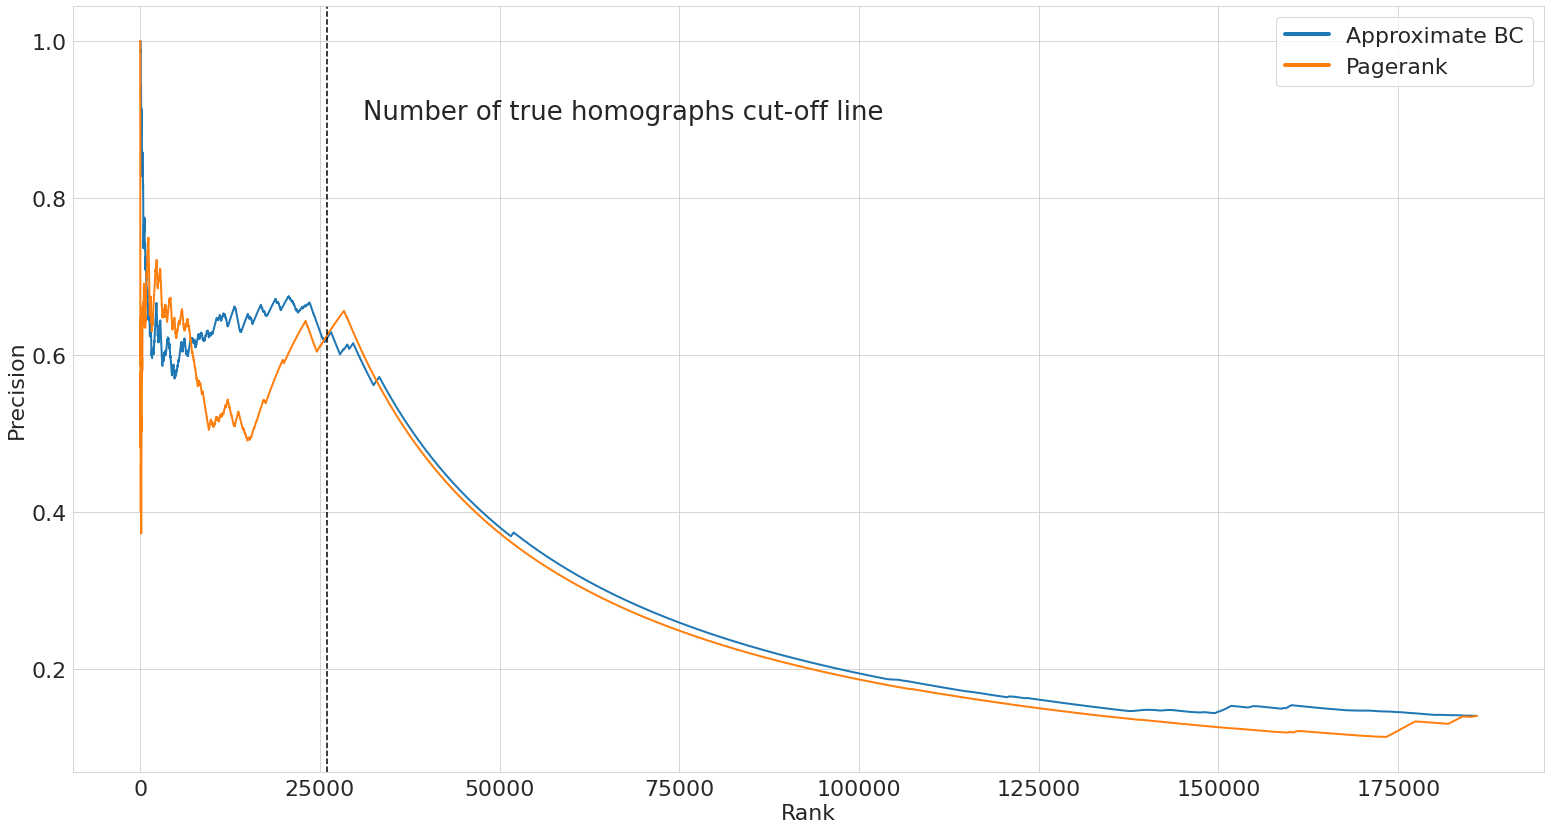

In [224]:
# Precision
ranks = list(range(1,df.shape[0] +1))

measure_names = ['Approximate BC', 'Pagerank']
for (measure, measure_name) in zip(measures, measure_names):
    plt.plot(ranks, df.sort_values(by=[measure+'_rank'])[measure+'_precision'].values, label=measure_name, linewidth=2)

plt.axvline(x=num_true_homographs, color='black', linestyle='--')
plt.text(num_true_homographs + 5000, 0.90,'Number of true homographs cut-off line', fontsize=26)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
# plt.savefig('figures/centrality_analysis/precision.svg')

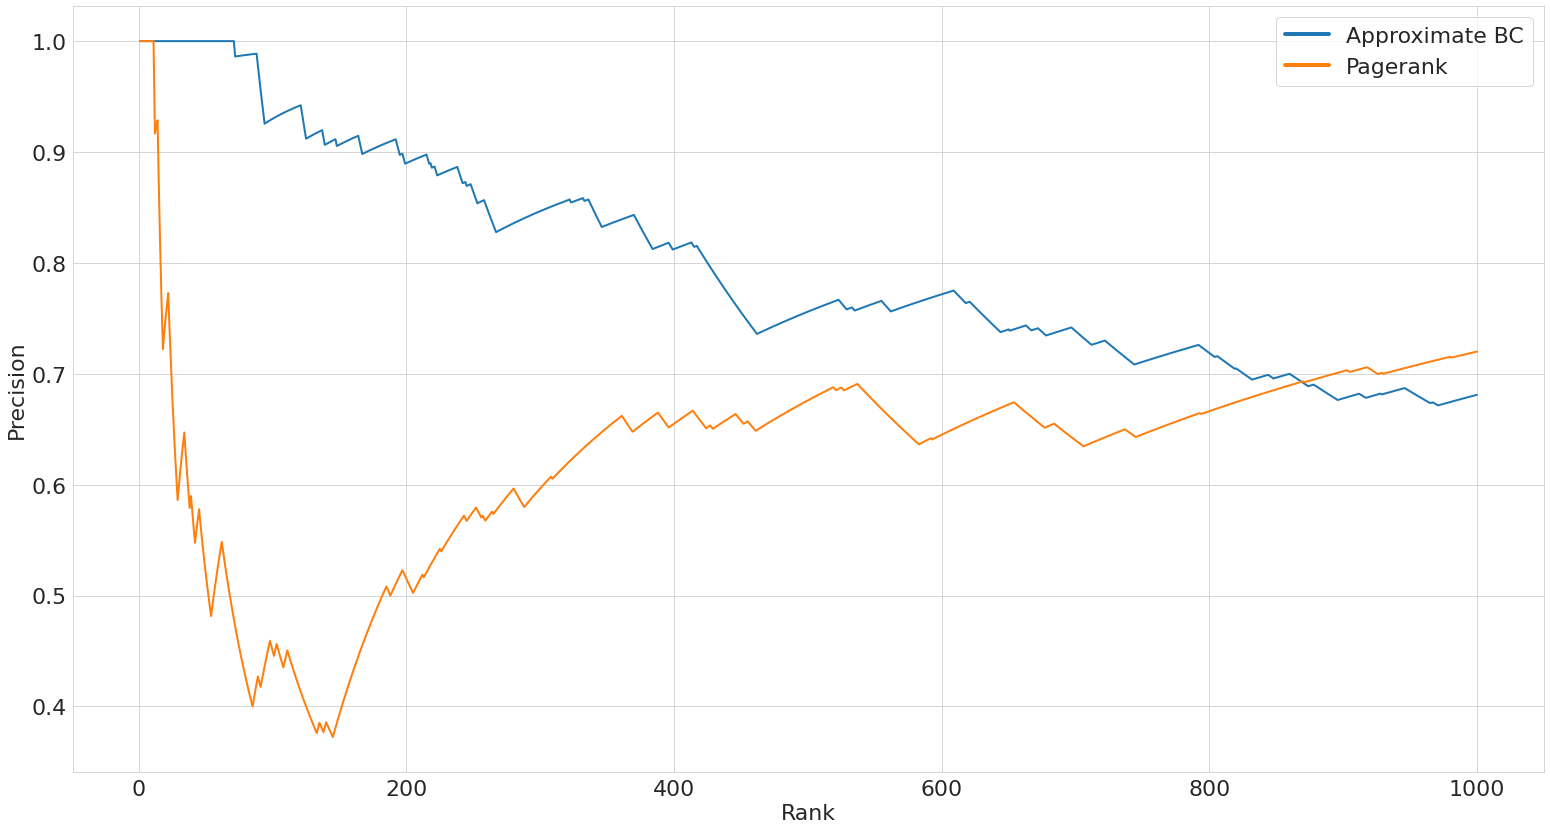

In [225]:
k = 1000
ranks = list(range(1, k+1))

for (measure, measure_name) in zip(measures, measure_names):
    vals = df.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k]
    plt.plot(ranks, vals, label=measure_name, linewidth=2)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig('figures/centrality_analysis/tus_precision_zoom.svg')

## Improved BC

In [226]:
# Compute the size of the connected component for each node in the graph
node_to_comp_size = {}
for s in nx.connected_components(g):
    for node in s:
        node_to_comp_size[node] = len(s)

df['con_comp_size'] = df['node'].map(node_to_comp_size)
df[df['is_homograph'] == True]['con_comp_size'].value_counts()

110000    22517
3280       3165
281         166
255         160
276          27
Name: con_comp_size, dtype: int64

In [227]:
def get_combined_score(df, bc_weight=0.5):
    '''
    Return the combined score as an numpy array in the order of the node in the data frame

    '''
    pg_weight = 1 - bc_weight
    scaler = MinMaxScaler()

    combined_score = (df['approximate_betweeness_centrality_norm'] * bc_weight + df['pagerank_norm'] * pg_weight).to_numpy().reshape(-1,1)
    return scaler.fit_transform(combined_score)[:,0]

In [228]:
bc = df['approximate_betweenness_centrality'].to_numpy().reshape(-1,1)
df['approximate_betweeness_centrality_norm'] = scaler.fit_transform(bc)[:,0]

In [234]:
df['BC_norm_with_card'] = df['approximate_betweeness_centrality_norm'] / df['cardinality']
df['BC_norm_with_card'] = normalize_series(df['BC_norm_with_card'])
# df[['node', 'approximate_betweeness_centrality_norm', 'BC_norm_with_card', 'cardinality']]

df = calculate_measures(df, 'BC_norm_with_card', num_true_homographs)
f1_score_bc = df[df['approximate_betweenness_centrality_rank'] == num_true_homographs]['approximate_betweenness_centrality_f1_score'].values[0]
f1_score_bc_with_card = df[df['BC_norm_with_card_rank'] == num_true_homographs]['BC_norm_with_card_f1_score'].values[0]
f1_pagerank = df[df['pagerank_rank'] == num_true_homographs]['pagerank_f1_score'].values[0]
print("Unique scores using BC:", len(df['approximate_betweeness_centrality_norm'].unique()))
print("Unique scores using BC-norm-with-card:", len(df['BC_norm_with_card'].unique()))
print("F1-score using BC:", f1_score_bc)
print("F1-score using BC-norm-with-card:", f1_score_bc_with_card)
print("F1-score using pagerank:", f1_pagerank)
df.sort_values(by='BC_norm_with_card_rank')[['node', 'is_homograph', 'approximate_betweeness_centrality_norm', 'BC_norm_with_card', 'cardinality']].head()

Unique scores using BC: 2796
Unique scores using BC-norm-with-card: 2800
F1-score using BC: 0.6218936047628193
F1-score using BC-norm-with-card: 0.619473785289034
F1-score using pagerank: 0.6255809487228731


,node,is_homograph,approximate_betweeness_centrality_norm,BC_norm_with_card,cardinality
191384,Moderate,True,0.003158,1.000000,8
191391,Strong,True,0.003903,0.988739,10
104,MND Health&Nutrition,True,0.013501,0.977287,35
70313,.,True,0.435798,0.933314,1183
122579,Cardiff University,True,0.141085,0.909527,393


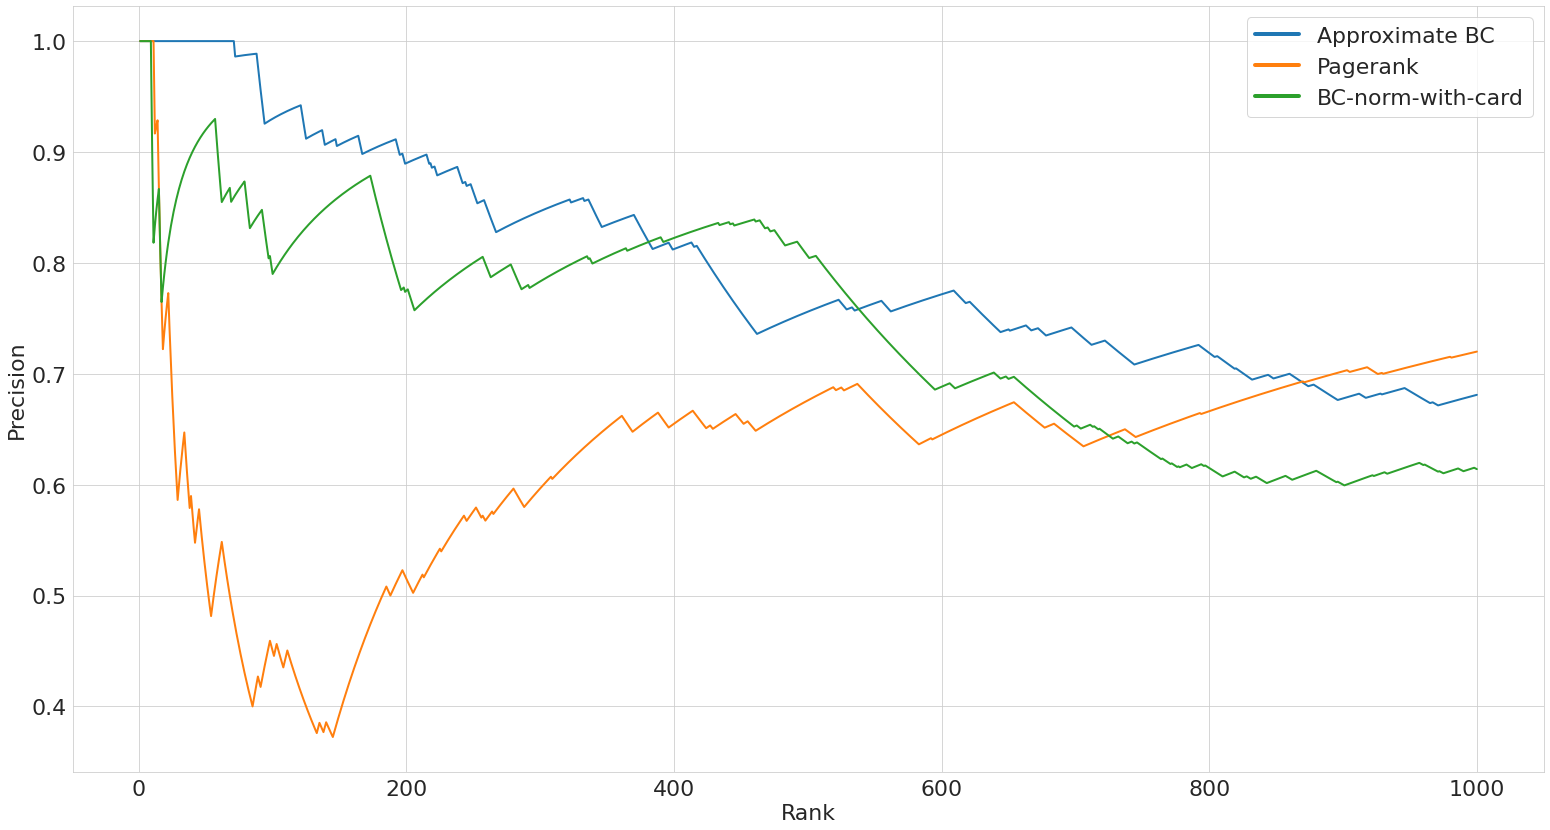

In [231]:
k = 1000
ranks = list(range(1, k+1))

measure_names = ['Approximate BC', 'Pagerank', 'BC-norm-with-card']
measures = ['approximate_betweenness_centrality', 'pagerank', 'BC_norm_with_card']
for (measure, measure_name) in zip(measures, measure_names):
    vals = df.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k]
    plt.plot(ranks, vals, label=measure_name, linewidth=2)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig('figures/centrality_analysis/tus_precision_zoom.svg')

In [235]:
num_true_homographs

26035

In [183]:
scaler = MinMaxScaler()

# Scale the BC and PageRank scores to be between 0 and 1
bc = df['approximate_betweenness_centrality'].to_numpy().reshape(-1,1)
pg = df['pagerank'].to_numpy().reshape(-1,1)
df['approximate_betweeness_centrality_norm'] = scaler.fit_transform(bc)[:,0]
df['pagerank_norm'] = scaler.fit_transform(pg)[:,0]

bc_weights = np.linspace(0,1,1000)
f1_scores = []
for bc_weight in tqdm(bc_weights):
    df['combined_score'] = get_combined_score(df, bc_weight=bc_weight)
    df = calculate_measures(df, 'combined_score', num_true_homographs)

    f1_score = df[df['combined_score_rank'] == num_true_homographs]['combined_score_f1_score'].values[0]
    f1_scores.append(f1_score)
    # print('BC weight:', bc_weight, 'at k =', num_true_homographs, 'the combined f1-score is:', f1_score)

  2%|▎         | 25/1000 [00:06<04:04,  3.99it/s]


KeyboardInterrupt: 

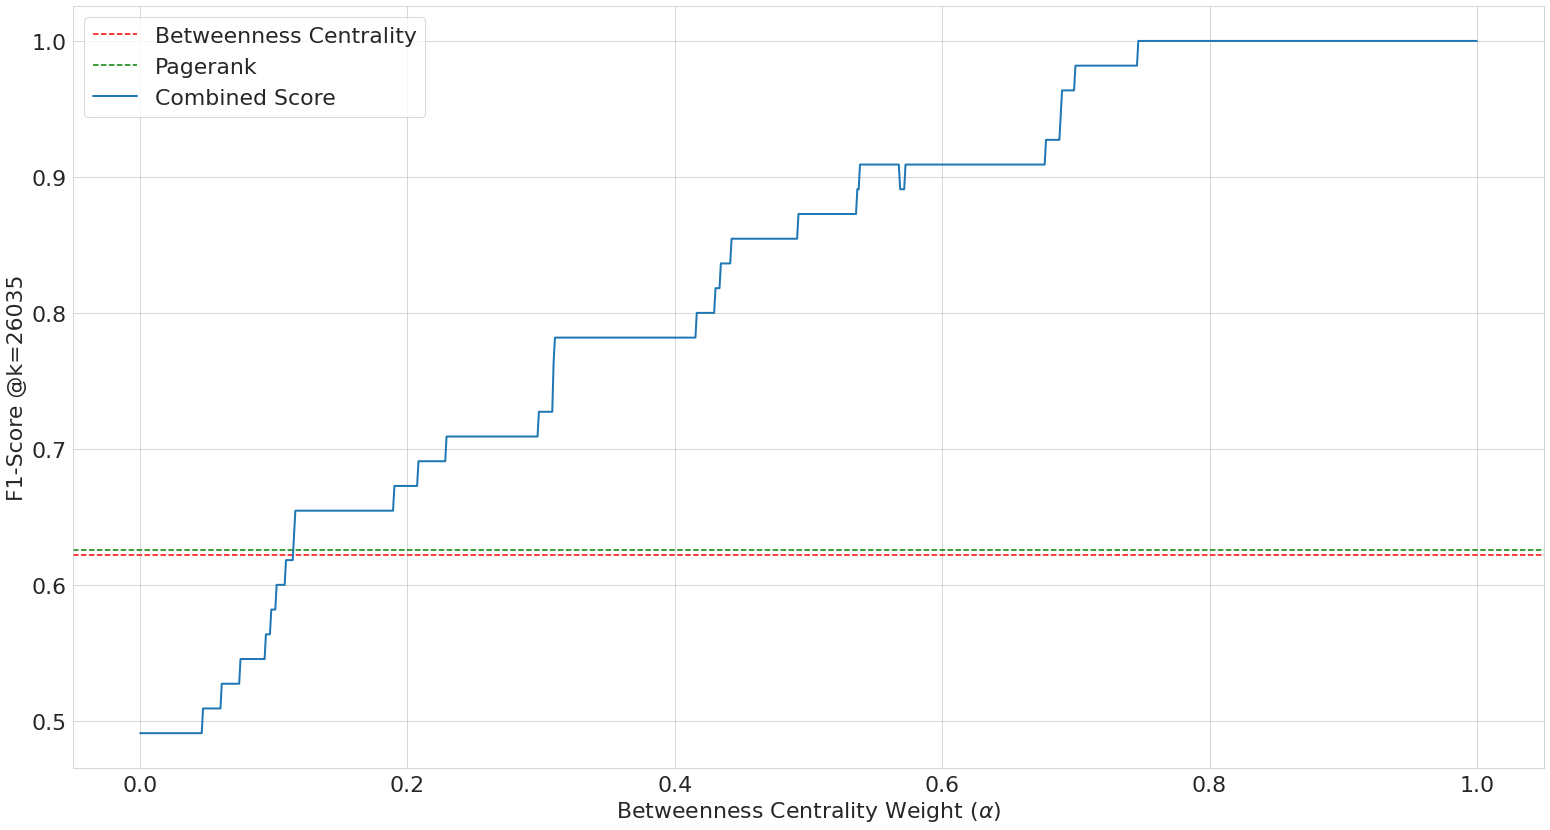

In [239]:
plt.axhline(y=df[df['approximate_betweenness_centrality_rank'] == num_true_homographs]['approximate_betweenness_centrality_f1_score'].values[0], label='Betweenness Centrality', color='red', linestyle='--')
plt.axhline(y=df[df['pagerank_rank'] == num_true_homographs]['pagerank_f1_score'].values[0], label='Pagerank', color='green', linestyle='--')

plt.plot(bc_weights, f1_scores, label='Combined Score', linewidth=2)

plt.xlabel(r'Betweenness Centrality Weight ($\alpha$)')
plt.ylabel('F1-Score @k=' + str(num_true_homographs))
leg = plt.legend()
plt.tight_layout()
plt.savefig('figures/centrality_analysis/TUS_combined_score_range.svg')

In [206]:
bc_weights = np.linspace(0,1,1000)
f1_scores = []
k=500
for bc_weight in tqdm(bc_weights):
    df['combined_score'] = get_combined_score(df, bc_weight=bc_weight)
    df = calculate_measures(df, 'combined_score', num_true_homographs)

    f1_score = df[df['combined_score_rank'] == k]['combined_score_f1_score'].values[0]
    f1_scores.append(f1_score)

100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]


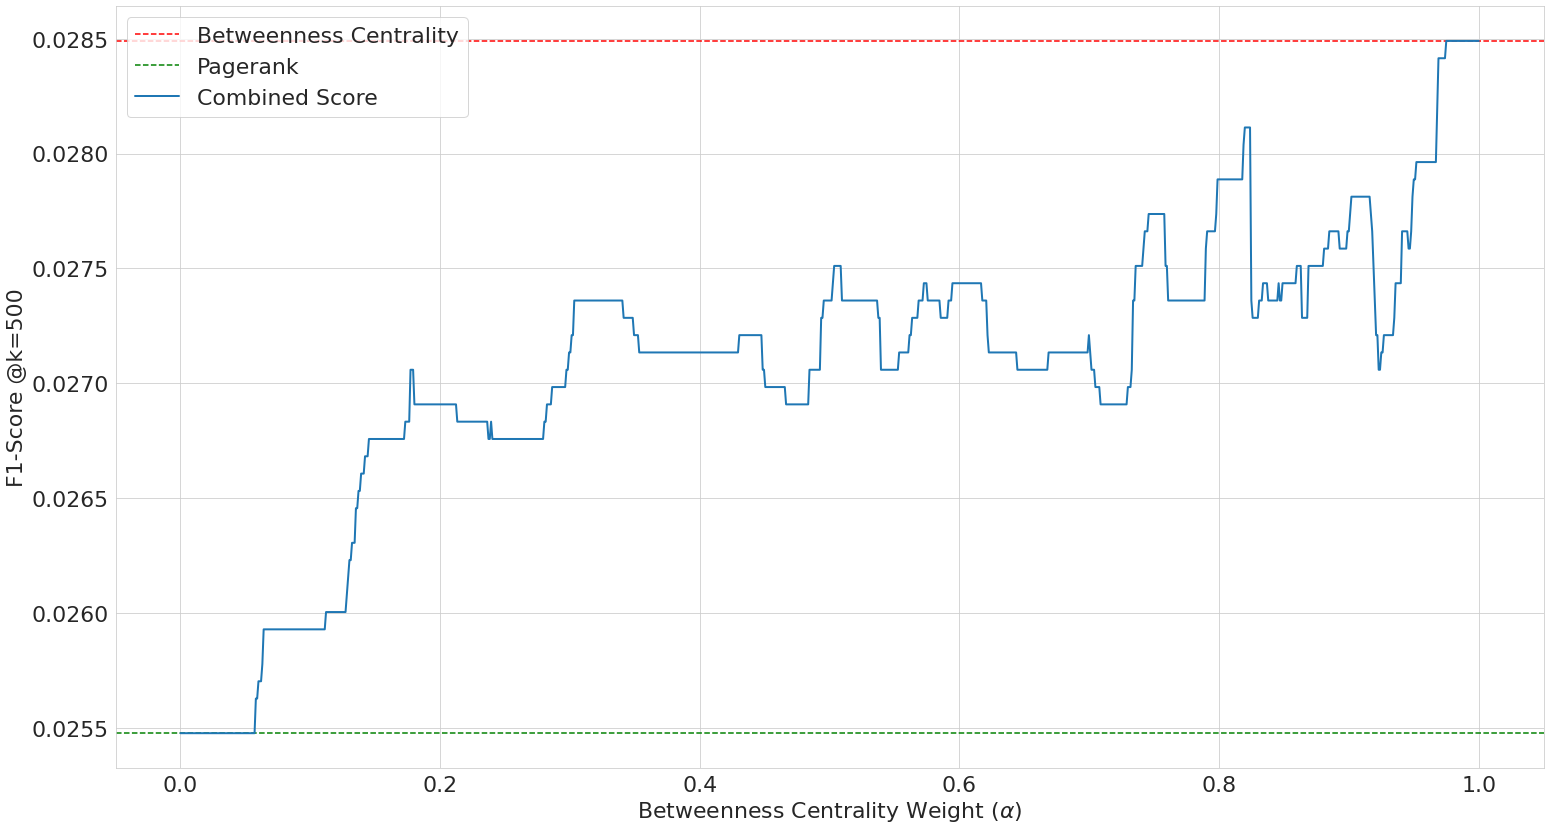

In [208]:
plt.axhline(y=df[df['approximate_betweenness_centrality_rank'] == k]['approximate_betweenness_centrality_f1_score'].values[0], label='Betweenness Centrality', color='red', linestyle='--')
plt.axhline(y=df[df['pagerank_rank'] == k]['pagerank_f1_score'].values[0], label='Pagerank', color='green', linestyle='--')

plt.plot(bc_weights, f1_scores, label='Combined Score', linewidth=2)

plt.xlabel(r'Betweenness Centrality Weight ($\alpha$)')
plt.ylabel('F1-Score @k=' + str(k))
leg = plt.legend()
plt.tight_layout()
plt.savefig('figures/centrality_analysis/TUS_combined_score_range_topk500.svg')

In [140]:
# Compute ranking correlations between pagerank and BC

BC_ranking = df['approximate_betweenness_centrality_rank'].values
pagerank_ranking = df['pagerank_rank'].values

print("Ranking correlations between BC and pagerank")
print("Kendall Tau:", stats.kendalltau(BC_ranking, pagerank_ranking))
print("Rank-biased Overlap:", rbo.RankingSimilarity(BC_ranking, pagerank_ranking).rbo())

print("BC vs. cardinality", stats.spearmanr(df['approximate_betweenness_centrality'].values, df['cardinality'].values))
print("Pagerank vs. cardinality", stats.spearmanr(df['pagerank'].values, df['cardinality'].values))

Ranking correlations between BC and pagerank
Kendall Tau: KendalltauResult(correlation=0.2304766408278638, pvalue=0.0)
Rank-biased Overlap: 0.7046017762756711
BC vs. cardinality SpearmanrResult(correlation=-0.08666140564923963, pvalue=8.950671382486723e-307)
Pagerank vs. cardinality SpearmanrResult(correlation=-0.040214281903237566, pvalue=2.0547526633980787e-67)


,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,katz,harmonic_closeness,pagerank,cardinality,approximate_betweenness_centrality_rank,approximate_betweenness_centrality_dense_rank,approximate_betweenness_centrality_precision,approximate_betweenness_centrality_recall,approximate_betweenness_centrality_f1_score,pagerank_rank,pagerank_dense_rank,pagerank_precision,pagerank_recall,pagerank_f1_score
191365,,cell,1.338285e-04,True,False,4.912452e-05,0.096994,0.000830,786,13,13.0,1.000000,0.000499,0.000998,1,1.0,1.000000,0.000038,0.000077
191380,Medium,cell,1.502401e-08,True,False,1.004069e-05,0.068818,0.000192,9,9552,2012.0,0.622487,0.228385,0.334167,2,2.0,1.000000,0.000077,0.000154
191387,Coarse,cell,1.410845e-08,True,False,9.593390e-06,0.068745,0.000182,9,9742,2029.0,0.627181,0.234684,0.341560,3,3.0,1.000000,0.000115,0.000230
191382,Fine,cell,1.036315e-08,True,False,8.392645e-06,0.068548,0.000155,9,10698,2079.0,0.644700,0.264913,0.375521,4,4.0,1.000000,0.000154,0.000307
191391,Strong,cell,2.492179e-06,True,False,7.080913e-06,0.082054,0.000130,10,387,279.0,0.813953,0.012099,0.023844,5,5.0,1.000000,0.000192,0.000384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,CARMAN,cell,0.000000e+00,False,False,9.933524e-07,0.084747,0.000001,257,127223,2796.0,0.157967,0.771922,0.262264,185937,3011.0,0.140021,1.000000,0.245646
9883,WABUSH LAKE,cell,0.000000e+00,False,False,9.933524e-07,0.084747,0.000001,257,127220,2796.0,0.157970,0.771922,0.262269,185938,3011.0,0.140020,1.000000,0.245644
9889,OAK POINT,cell,0.000000e+00,False,False,9.933524e-07,0.084747,0.000001,257,127216,2796.0,0.157975,0.771922,0.262276,185939,3011.0,0.140019,1.000000,0.245643
42206,Spur Mile,cell,0.000000e+00,False,False,6.539917e-07,0.082976,0.000001,31,106103,2796.0,0.184962,0.753793,0.297038,185940,3012.0,0.140018,1.000000,0.245642


# Synthetic Benchmark

In [198]:
# Run the following cell to produce "graph_stats_with_groundtruth_df.pickle" file if it doesn't exist

# df_path = 'output/synthetic_example_bipartite/graph_stats_df.pickle'
# ground_truth_path = 'ground_truth/synthetic_example_groundtruth_dict.pickle'

# # Load groundtruth
# gt = pickle.load(open(ground_truth_path, 'rb'))

# # Load Dataframe
# df_sb = pickle.load(open(df_path, 'rb'))
# cell_nodes = df_sb[df_sb['node_type'] == 'cell']['node'].values

# # Populate the 'is_homograph' column
# gt_labels = {}
# for node in cell_nodes:
#     if gt[node] == 'homograph': 
#         gt_labels[node] = True
#     else:
#         gt_labels[node] = False

# df_sb['is_homograph'] = df_sb['node'].map(gt_labels)

# # Save the dataframe to file
# save_path = "output/synthetic_example_bipartite/graph_stats_with_groundtruth_df.pickle"
# df_sb.to_pickle(save_path)

In [199]:
df_path = 'output/synthetic_example_bipartite/graph_stats_with_groundtruth_df.pickle'
graph_path = '../graph_construction/combined_graphs_output/synthetic_benchmark_bipartite/bipartite/bipartite.graph'

# Load Graph
g_sb = pickle.load(open(graph_path, 'rb'))

# Load Dataframe
df_sb = pickle.load(open(df_path, 'rb'))
df_sb = df_sb[df_sb['node_type'] == 'cell']

# Consider only cell nodes with degree greater than 1
cell_nodes = df_sb['node'].values
nodes_with_degree_greater_than_1 = [n for n in cell_nodes if g_sb.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'nodes with degree greater than 1')

df_sb = df_sb.loc[df_sb['node'].isin(nodes_with_degree_greater_than_1)]
df_sb

There are 1230 nodes with degree greater than 1


,node,node_type,betweenness_centrality,is_homograph,pagerank
3,France,cell,2.495051e-07,False,0.000046
5,Lesotho,cell,1.169126e-08,False,0.000019
7,China,cell,2.495051e-07,False,0.000046
10,Sweden,cell,2.495051e-07,False,0.000046
11,Sydney,cell,9.810583e-03,True,0.000052
...,...,...,...,...,...
15332,MM,cell,3.259492e-08,False,0.000029
15392,AI,cell,3.259492e-08,False,0.000029
15533,CG,cell,3.259492e-08,False,0.000029
15547,SV,cell,3.259492e-08,False,0.000029


In [200]:
num_true_homographs = df_sb['is_homograph'].value_counts()[True]
print("Based on ground truth there are", num_true_homographs, 'homographs.')

measures = ['betweenness_centrality', 'pagerank']
for measure in measures:
    df_sb = calculate_measures(df_sb, measure, num_true_homographs)

# Compute F1-scores at num_homographs
for measure in measures:
    print('For', measure, 'at k =', num_true_homographs, 'the f1-score is:', df_sb[df_sb[measure+'_rank'] == num_true_homographs][measure+'_f1_score'].values[0])

# Add cardinality column
add_cardinality_column(df_sb, g_sb)

# Add degree column
degrees = {}
for node in df_sb['node']:
    degrees[node] = len(g_sb[node])
df_sb['degree'] = df_sb['node'].map(degrees)

df_sb.head()

 10%|▉         | 121/1230 [00:00<00:00, 1203.53it/s]Based on ground truth there are 55 homographs.
For betweenness_centrality at k = 55 the f1-score is: 0.6909090909090909
For pagerank at k = 55 the f1-score is: 0.6181818181818182
100%|██████████| 1230/1230 [00:00<00:00, 2201.45it/s]


,node,node_type,betweenness_centrality,is_homograph,pagerank,betweenness_centrality_rank,betweenness_centrality_dense_rank,betweenness_centrality_precision,betweenness_centrality_recall,betweenness_centrality_f1_score,pagerank_rank,pagerank_dense_rank,pagerank_precision,pagerank_recall,pagerank_f1_score,cardinality,degree
546,Virginia,cell,0.012067,True,0.000073,14,12.0,1.0,0.254545,0.405797,1,1.0,1.0,0.018182,0.035714,1956,3
258,Cuba,cell,0.006394,True,0.000068,20,16.0,1.0,0.363636,0.533333,2,2.0,1.0,0.036364,0.070175,1172,8
723,Jamaica,cell,0.009349,True,0.000068,18,14.0,1.0,0.327273,0.493151,3,3.0,1.0,0.054545,0.103448,1166,8
2384,Jaguar,cell,0.054344,True,0.000064,1,1.0,1.0,0.018182,0.035714,4,4.0,1.0,0.072727,0.135593,1170,3
1133,GT,cell,0.005336,True,0.000060,21,17.0,1.0,0.381818,0.552632,5,5.0,1.0,0.090909,0.166667,672,4


In [201]:
# Compute ranking correlations between pagerank and BC
BC_ranking = df_sb['betweenness_centrality_rank'].values
pagerank_ranking = df_sb['pagerank_rank'].values

print("Ranking correlations between BC and pagerank")
print("Kendall Tau:", stats.kendalltau(BC_ranking, pagerank_ranking))
print("Rank-biased Overlap:", rbo.RankingSimilarity(BC_ranking, pagerank_ranking).rbo())

Ranking correlations between BC and pagerank
Kendall Tau: KendalltauResult(correlation=0.4724853969451004, pvalue=5.3547212676443215e-136)
Rank-biased Overlap: 0.7466823775042009


In [202]:
# Compute ranking correlations for pagerank and BC ranks with respect to cardinality
print("BC vs. cardinality", stats.spearmanr(df_sb['betweenness_centrality'].values, df_sb['cardinality'].values))
print("BC vs. degree", stats.spearmanr(df_sb['betweenness_centrality'].values, df_sb['degree'].values))
print("Pagerank vs. cardinality", stats.spearmanr(df_sb['pagerank'].values, df_sb['cardinality'].values))
print("Pagerank vs. degree", stats.spearmanr(df_sb['pagerank'].values, df_sb['degree'].values))

BC vs. cardinality SpearmanrResult(correlation=0.9104625117224558, pvalue=0.0)
BC vs. degree SpearmanrResult(correlation=-0.31057199512285355, pvalue=6.531651862586802e-29)
Pagerank vs. cardinality SpearmanrResult(correlation=0.5999272639474881, pvalue=4.0681241096550465e-121)
Pagerank vs. degree SpearmanrResult(correlation=0.0857344534423316, pvalue=0.0026184303731286904)


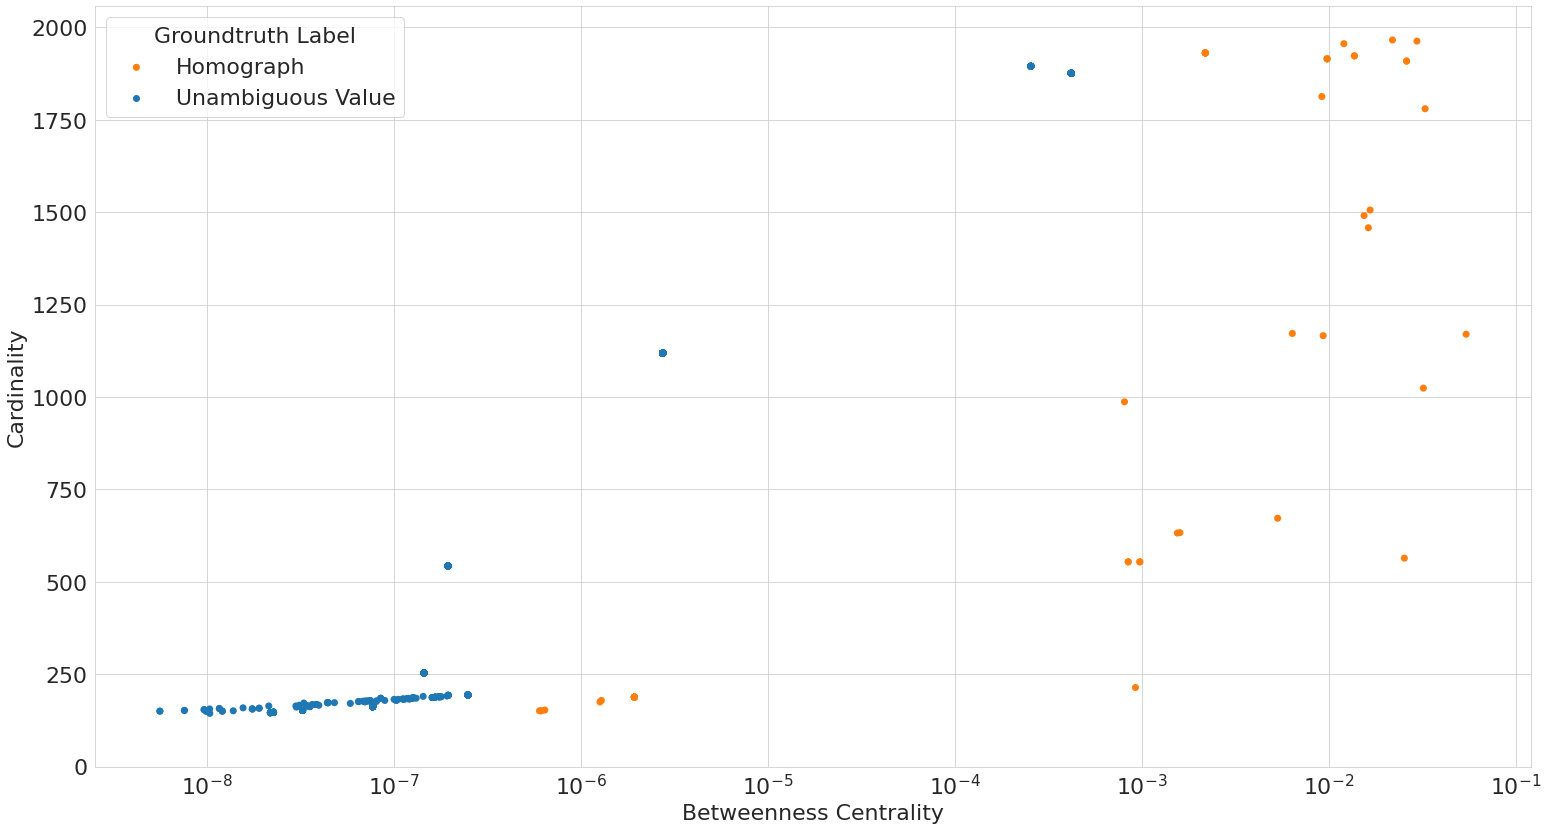

In [203]:
ax = sns.scatterplot(data=df_sb, x="betweenness_centrality", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='Betweenness Centrality', ylabel='Cardinality', xscale='log', ylim=(0, None))
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_BC_vs_cardinality.svg')

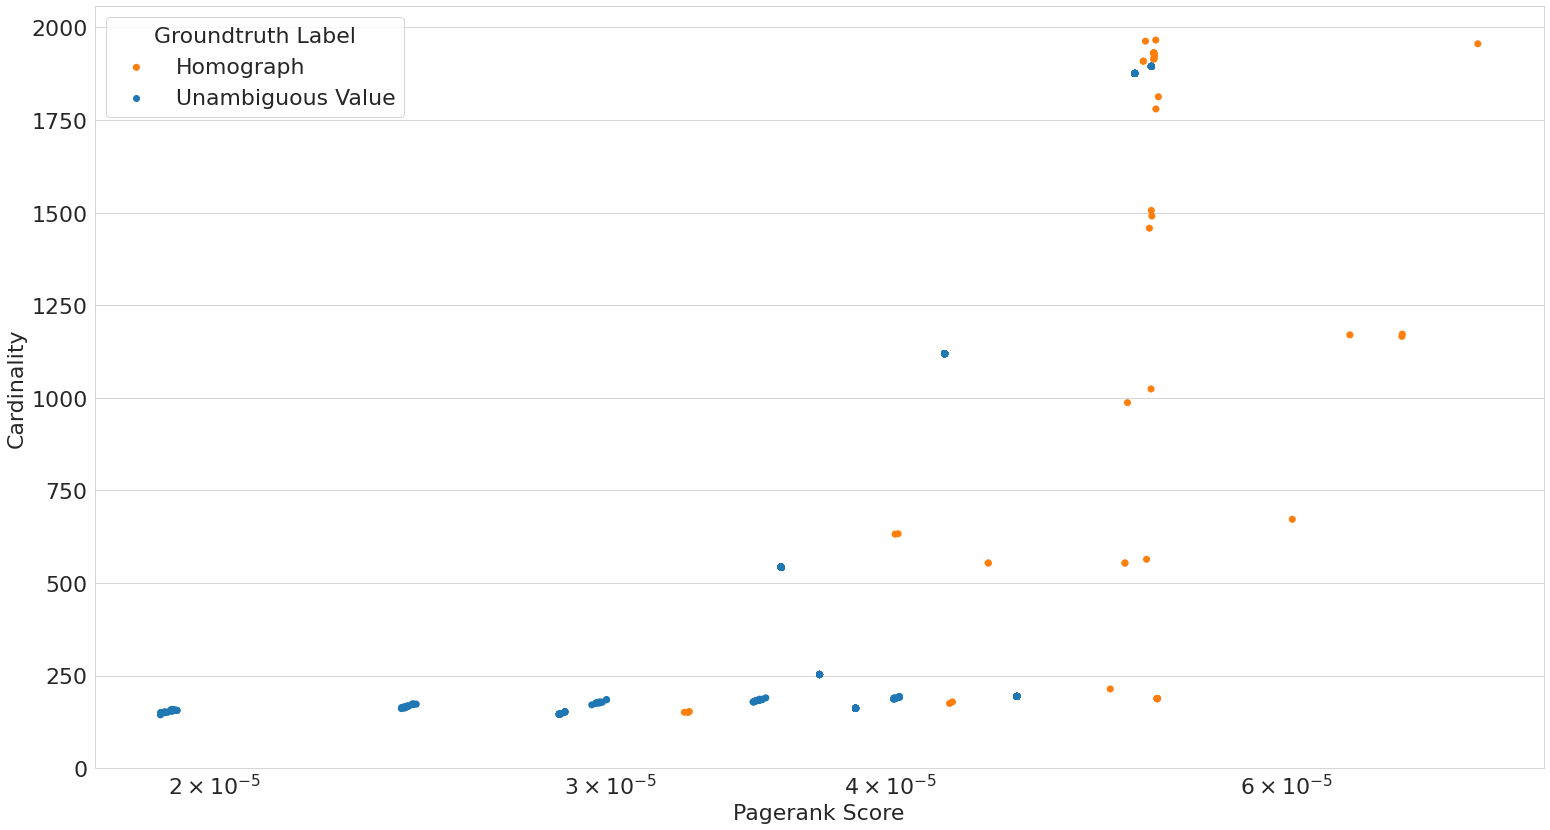

In [204]:
ax = sns.scatterplot(data=df_sb, x="pagerank", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='Pagerank Score', ylabel='Cardinality', xscale='log', ylim=(0, None))
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_pagerank_vs_cardinality.svg')

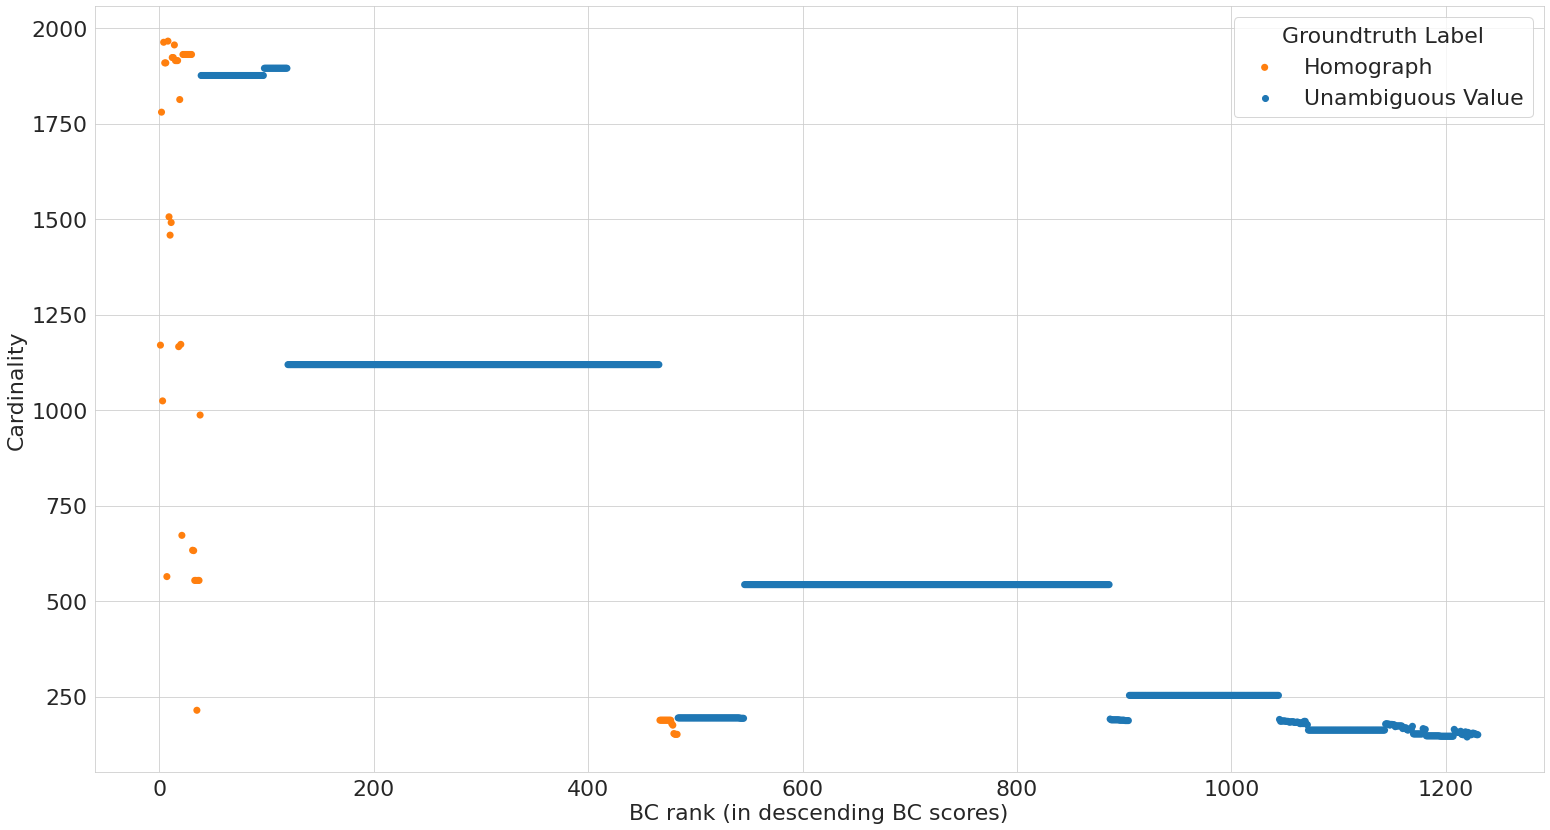

In [205]:
ax = sns.scatterplot(data=df_sb, x="betweenness_centrality_rank", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='BC rank (in descending BC scores)', ylabel='Cardinality')
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_BC_rank_vs_cardinality.svg')

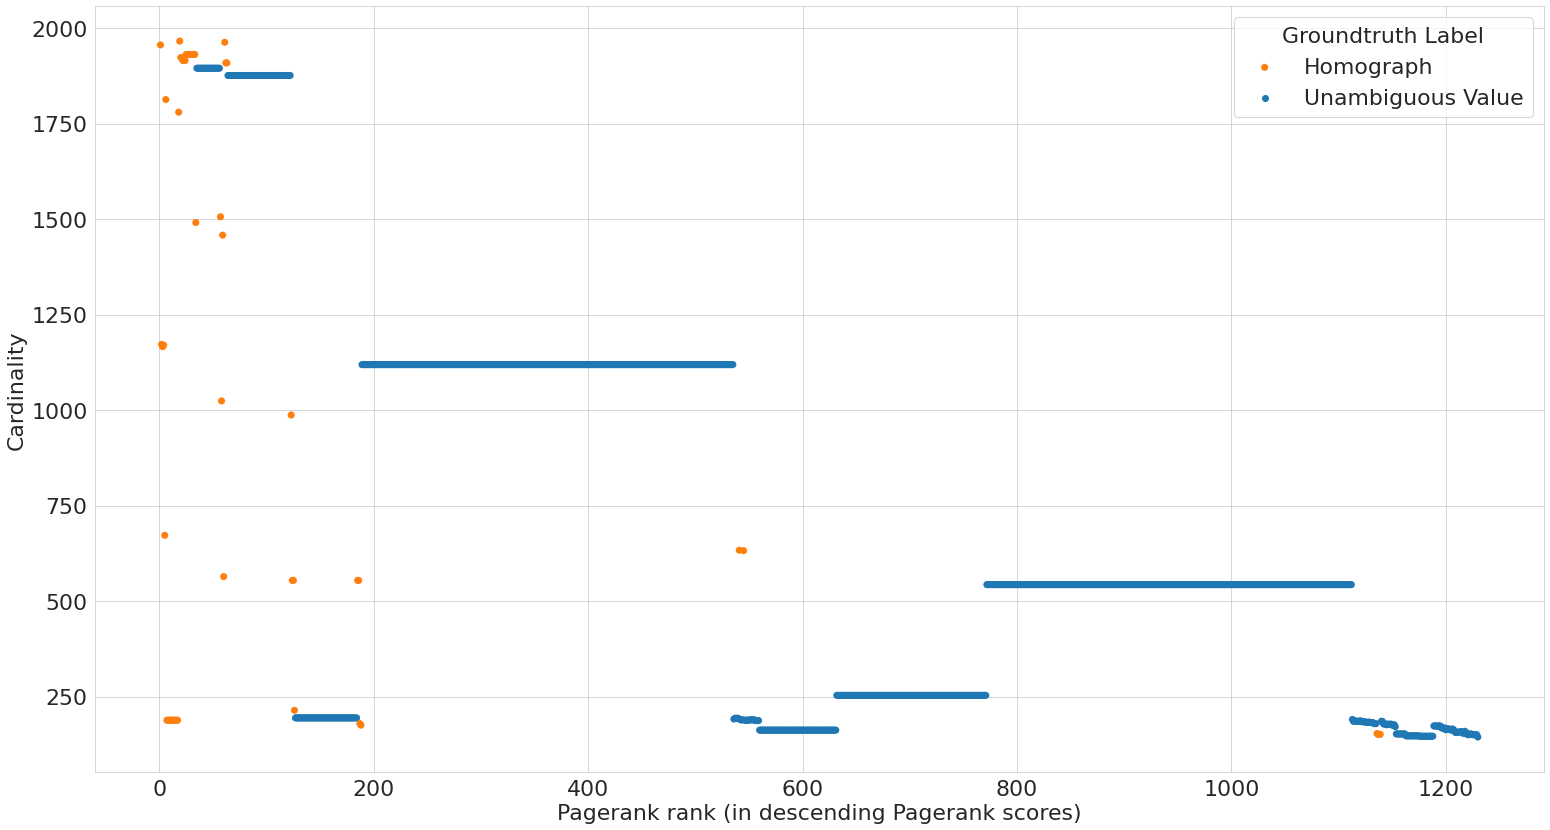

In [206]:
ax = sns.scatterplot(data=df_sb, x="pagerank_rank", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='Pagerank rank (in descending Pagerank scores)', ylabel='Cardinality')
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_pagerank_rank_vs_cardinality.svg')

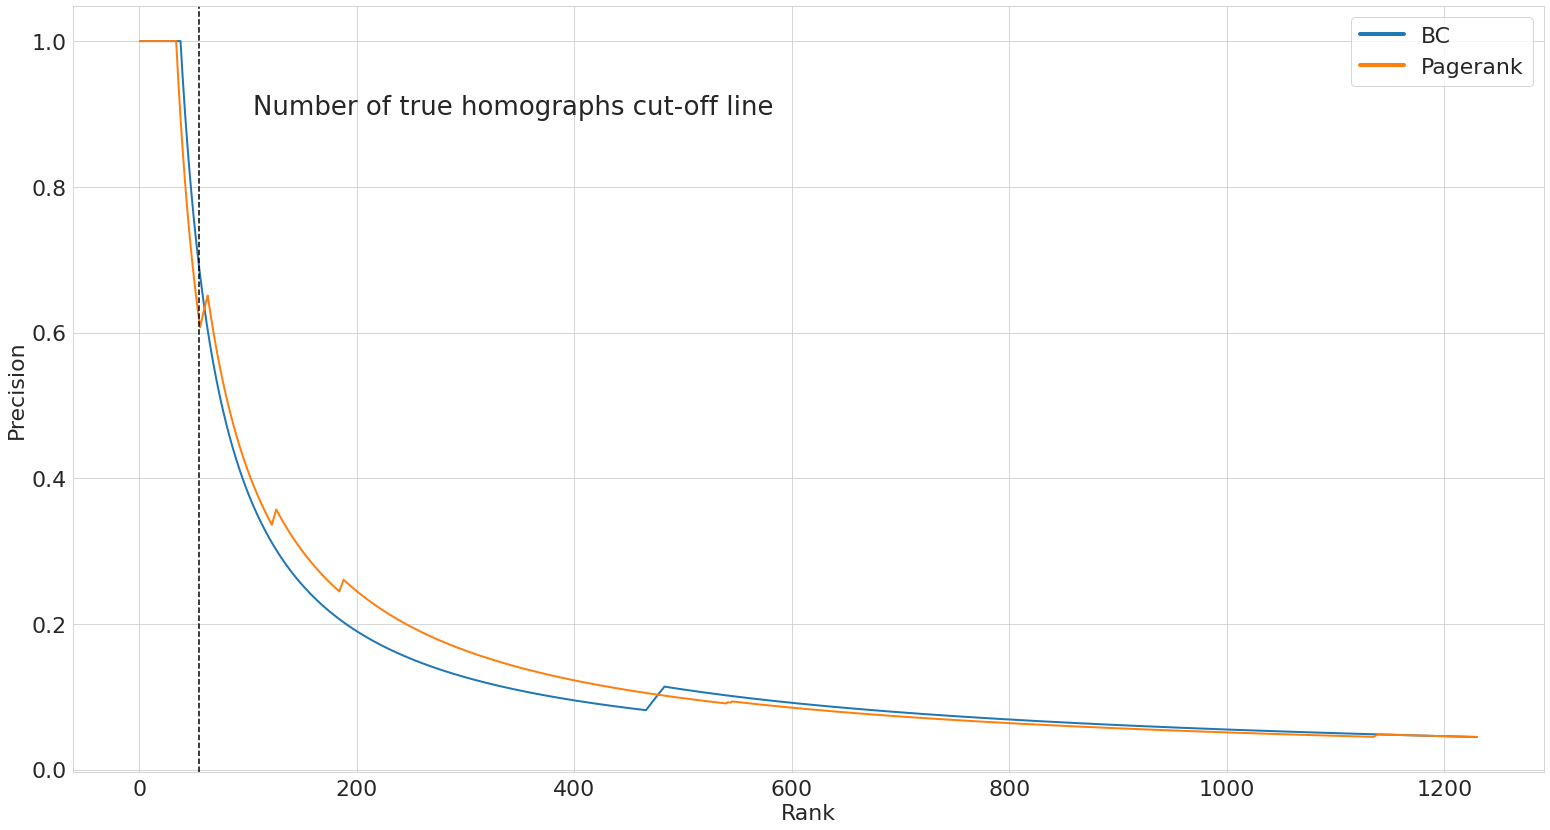

In [207]:
# Precision
k = df_sb.shape[0]
ranks = list(range(1, k+1))

measure_names = ['BC', 'Pagerank']
for (measure, measure_name) in zip(measures, measure_names):
    plt.plot(ranks, df_sb.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k], label=measure_name, linewidth=2)

plt.axvline(x=num_true_homographs, color='black', linestyle='--')
plt.text(num_true_homographs + 50, 0.90,'Number of true homographs cut-off line', fontsize=26)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_precision.svg')

## Combined Score

In [208]:
def get_combined_score_sb(df, bc_weight=0.5):
    '''
    Return the combined score as an numpy array in the order of the node in the data frame

    '''
    pg_weight = 1 - bc_weight
    scaler = MinMaxScaler()

    combined_score = (df['betweenness_centrality_norm'] * bc_weight + df['pagerank_norm'] * pg_weight).to_numpy().reshape(-1,1)
    return scaler.fit_transform(combined_score)[:,0]

def normalize_series(series):
    scaler = MinMaxScaler()

    series = series.to_numpy().reshape(-1,1)
    series = scaler.fit_transform(series)[:,0]
    return series

In [209]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale the BC and PageRank scores to be between 0 and 1
bc = df_sb['betweenness_centrality'].to_numpy().reshape(-1,1)
pg = df_sb['pagerank'].to_numpy().reshape(-1,1)
df_sb['betweenness_centrality_norm'] = scaler.fit_transform(bc)[:,0]
df_sb['pagerank_norm'] = scaler.fit_transform(pg)[:,0]


bc_weights = np.linspace(0,1,1000)
f1_scores = []
for bc_weight in bc_weights:
    df_sb['combined_score'] = get_combined_score_sb(df_sb, bc_weight=bc_weight)
    df_sb = calculate_measures(df_sb, 'combined_score', num_true_homographs)

    f1_score = df_sb[df_sb['combined_score_rank'] == num_true_homographs]['combined_score_f1_score'].values[0]
    f1_scores.append(f1_score)

print("Maximum F1-score is:", max(f1_scores))


Maximum F1-score is: 0.7454545454545455


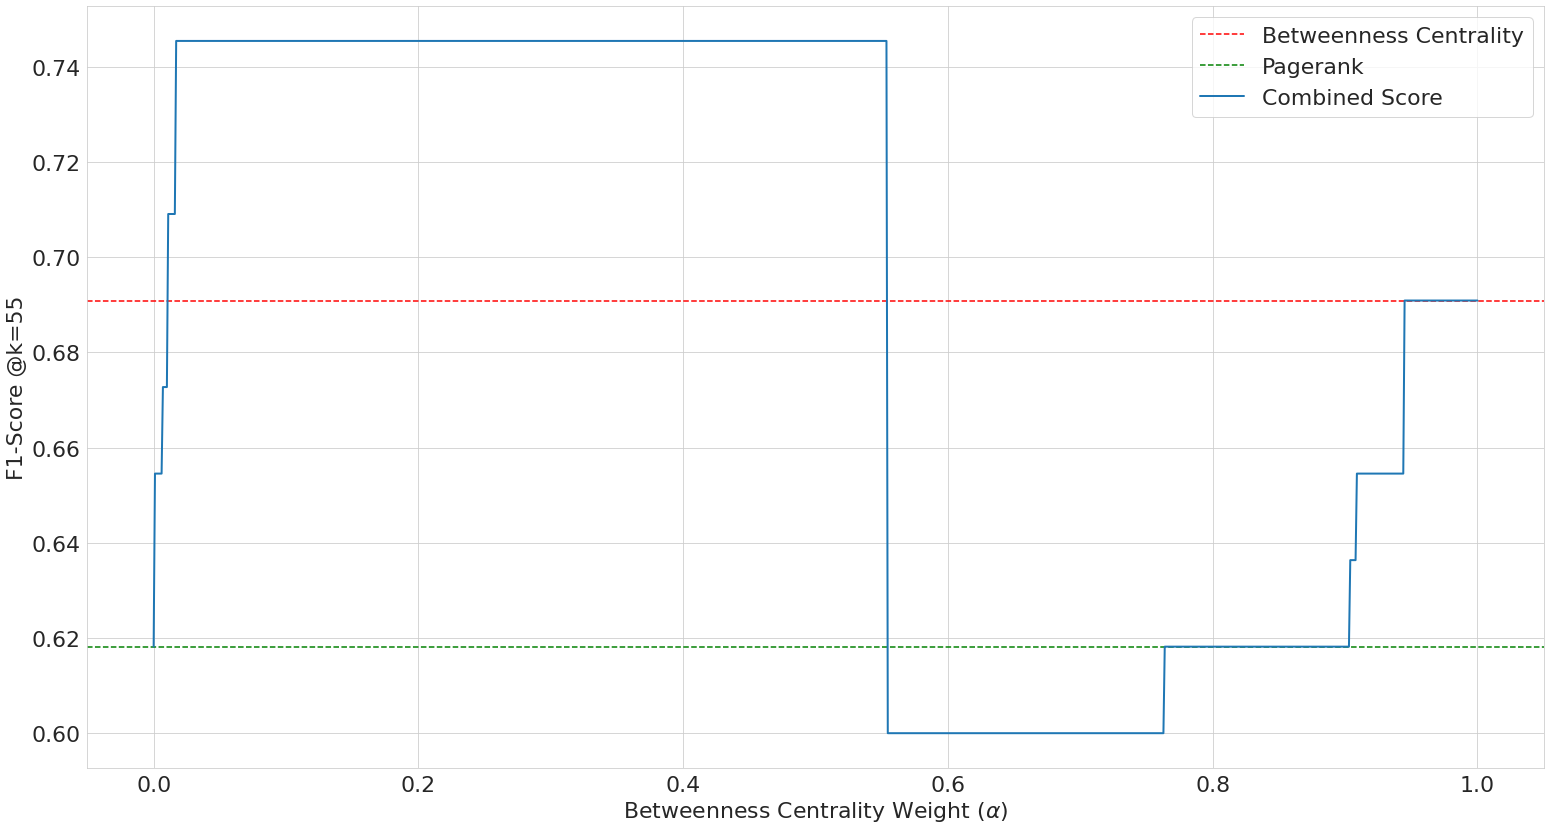

In [210]:
plt.axhline(y=df_sb[df_sb['betweenness_centrality_rank'] == num_true_homographs]['betweenness_centrality_f1_score'].values[0], label='Betweenness Centrality', color='red', linestyle='--')
plt.axhline(y=df_sb[df_sb['pagerank_rank'] == num_true_homographs]['pagerank_f1_score'].values[0], label='Pagerank', color='green', linestyle='--')

plt.plot(bc_weights, f1_scores, label='Combined Score', linewidth=2)


plt.xlabel(r'Betweenness Centrality Weight ($\alpha$)')
plt.ylabel('F1-Score @k=55')
leg = plt.legend()
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_combined_score_range.svg')

In [211]:
df_sb['combined_score'] = get_combined_score_sb(df_sb, bc_weight=0.5)
df_sb = calculate_measures(df_sb, 'combined_score', num_true_homographs)

print('For the combined score at k =', num_true_homographs, 'the f1-score is:', df_sb[df_sb['combined_score_rank'] == num_true_homographs]['combined_score_f1_score'].values[0])

df_sb.sort_values(by='combined_score_rank').loc[df_sb['is_homograph'] == True][['node', 'betweenness_centrality_rank', 'pagerank_rank', 'combined_score_rank', 'combined_score']]

For the combined score at k = 55 the f1-score is: 0.7454545454545455


,node,betweenness_centrality_rank,pagerank_rank,combined_score_rank,combined_score
2384,Jaguar,1,4,1,1.000000
10229,Mace,2,18,2,0.667538
546,Virginia,14,1,3,0.666245
300,Lincoln,3,58,4,0.658045
4228,Heather,4,61,5,0.630294
6646,Charity,5,63,6,0.593643
5701,Leandra,6,62,7,0.593643
15222,Ram,7,60,8,0.588163
723,Jamaica,18,3,9,0.583923
981,Phoenix,8,19,10,0.558476


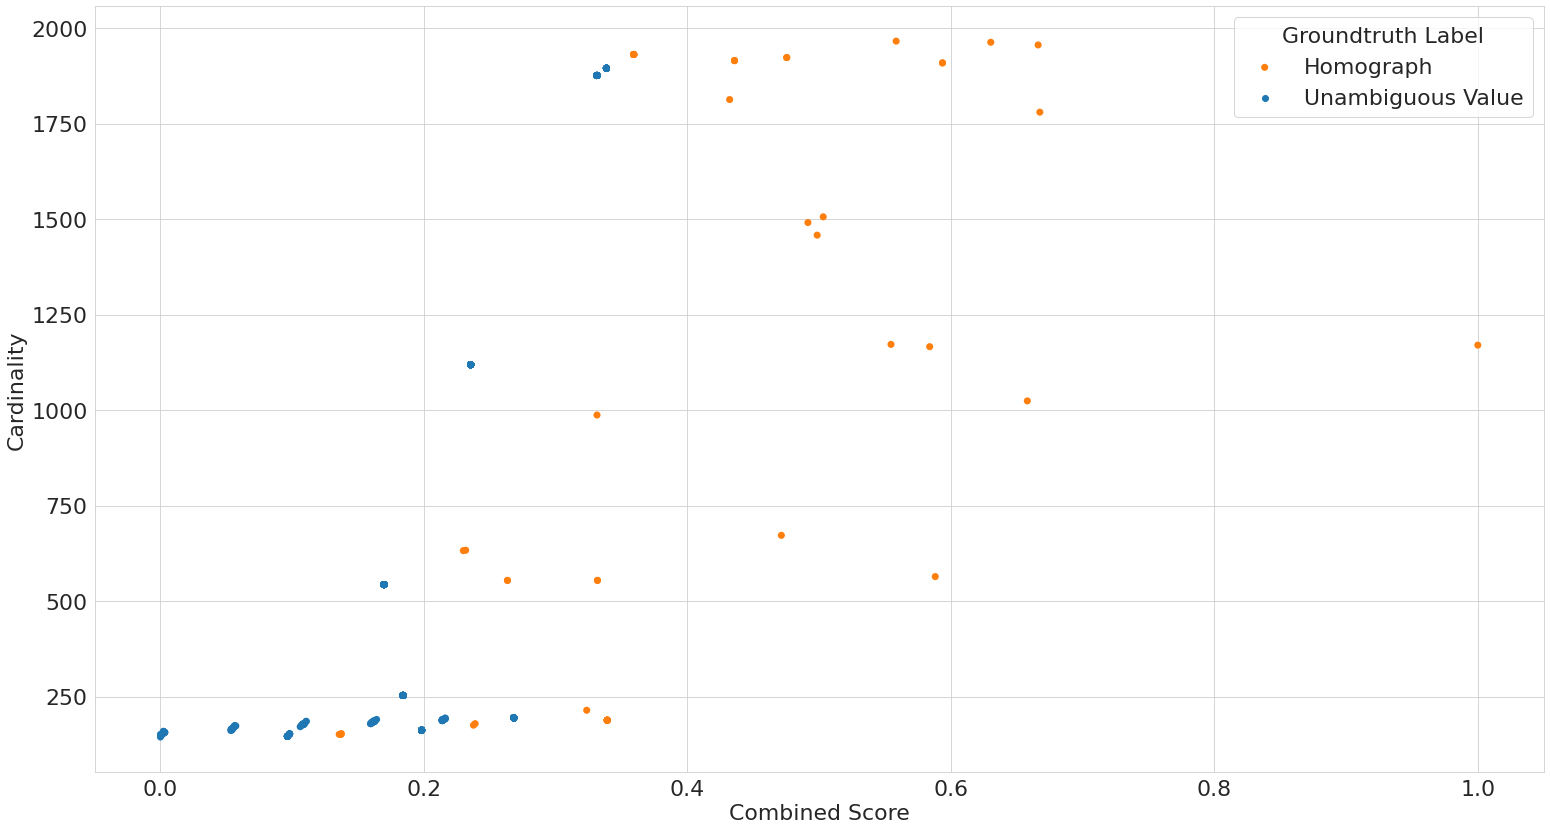

In [212]:
ax = sns.scatterplot(data=df_sb, x="combined_score", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='Combined Score', ylabel='Cardinality')
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.tight_layout()
# plt.savefig('figures/centrality_analysis/sb_BC_vs_cardinality.svg')

## Improving BC

In [213]:
# Compute the size of the connected component for each node in the graph
node_to_comp_size = {}
for s in nx.connected_components(g_sb):
    for node in s:
        node_to_comp_size[node] = len(s)

df_sb['con_comp_size'] = df_sb['node'].map(node_to_comp_size)
df_sb.head()
# df_sb.sort_values(by='betweenness_centrality_rank').loc[df_sb['is_homograph'] == True][['node', 'is_homograph', 'betweenness_centrality_rank', 'con_comp_size']]

,node,node_type,betweenness_centrality,is_homograph,pagerank,betweenness_centrality_rank,betweenness_centrality_dense_rank,betweenness_centrality_precision,betweenness_centrality_recall,betweenness_centrality_f1_score,...,degree,betweenness_centrality_norm,pagerank_norm,combined_score,combined_score_rank,combined_score_dense_rank,combined_score_precision,combined_score_recall,combined_score_f1_score,con_comp_size
2384,Jaguar,cell,0.054344,True,0.000064,1,1.0,1.0,0.018182,0.035714,...,3,1.000000,0.834224,1.000000,1,1.0,1.0,0.018182,0.035714,8696
10229,Mace,cell,0.032803,True,0.000052,2,2.0,1.0,0.036364,0.070175,...,2,0.603616,0.620797,0.667538,2,2.0,1.0,0.036364,0.070175,8696
546,Virginia,cell,0.012067,True,0.000073,14,12.0,1.0,0.254545,0.405797,...,3,0.222043,1.000000,0.666245,3,3.0,1.0,0.054545,0.103448,8696
300,Lincoln,cell,0.032120,True,0.000052,3,3.0,1.0,0.054545,0.103448,...,2,0.591048,0.615954,0.658045,4,4.0,1.0,0.072727,0.135593,8696
4228,Heather,cell,0.029653,True,0.000052,4,4.0,1.0,0.072727,0.135593,...,2,0.545644,0.610457,0.630294,5,5.0,1.0,0.090909,0.166667,8696


In [214]:
df_sb['BC_norm_with_card'] = df_sb['betweenness_centrality_norm'] / df_sb['cardinality']
df_sb['BC_norm_with_card'] = normalize_series(df_sb['BC_norm_with_card'])
df_sb[['node', 'betweenness_centrality_norm', 'cardinality', 'BC_norm_with_card']]

df_sb = calculate_measures(df_sb, 'BC_norm_with_card', num_true_homographs)
f1_score = df_sb[df_sb['BC_norm_with_card_rank'] == num_true_homographs]['BC_norm_with_card_f1_score'].values[0]
print(len(df_sb['BC_norm_with_card'].unique()))
df_sb.sort_values(by='BC_norm_with_card_rank')[['node', 'is_homograph', 'betweenness_centrality_norm', 'BC_norm_with_card', 'cardinality']].iloc[0:60]

100


,node,is_homograph,betweenness_centrality_norm,BC_norm_with_card,cardinality
2384,Jaguar,True,1.000000,1.000000,1170
15222,Ram,True,0.467289,0.969377,564
300,Lincoln,True,0.591048,0.675319,1024
10229,Mace,True,0.603616,0.396759,1780
4228,Heather,True,0.545644,0.325218,1963
6646,Charity,True,0.480543,0.294518,1909
5701,Leandra,True,0.480543,0.294518,1909
10915,Jimmy,True,0.300086,0.240810,1458
981,Phoenix,True,0.403722,0.240262,1966
10357,Elan,True,0.306588,0.238186,1506


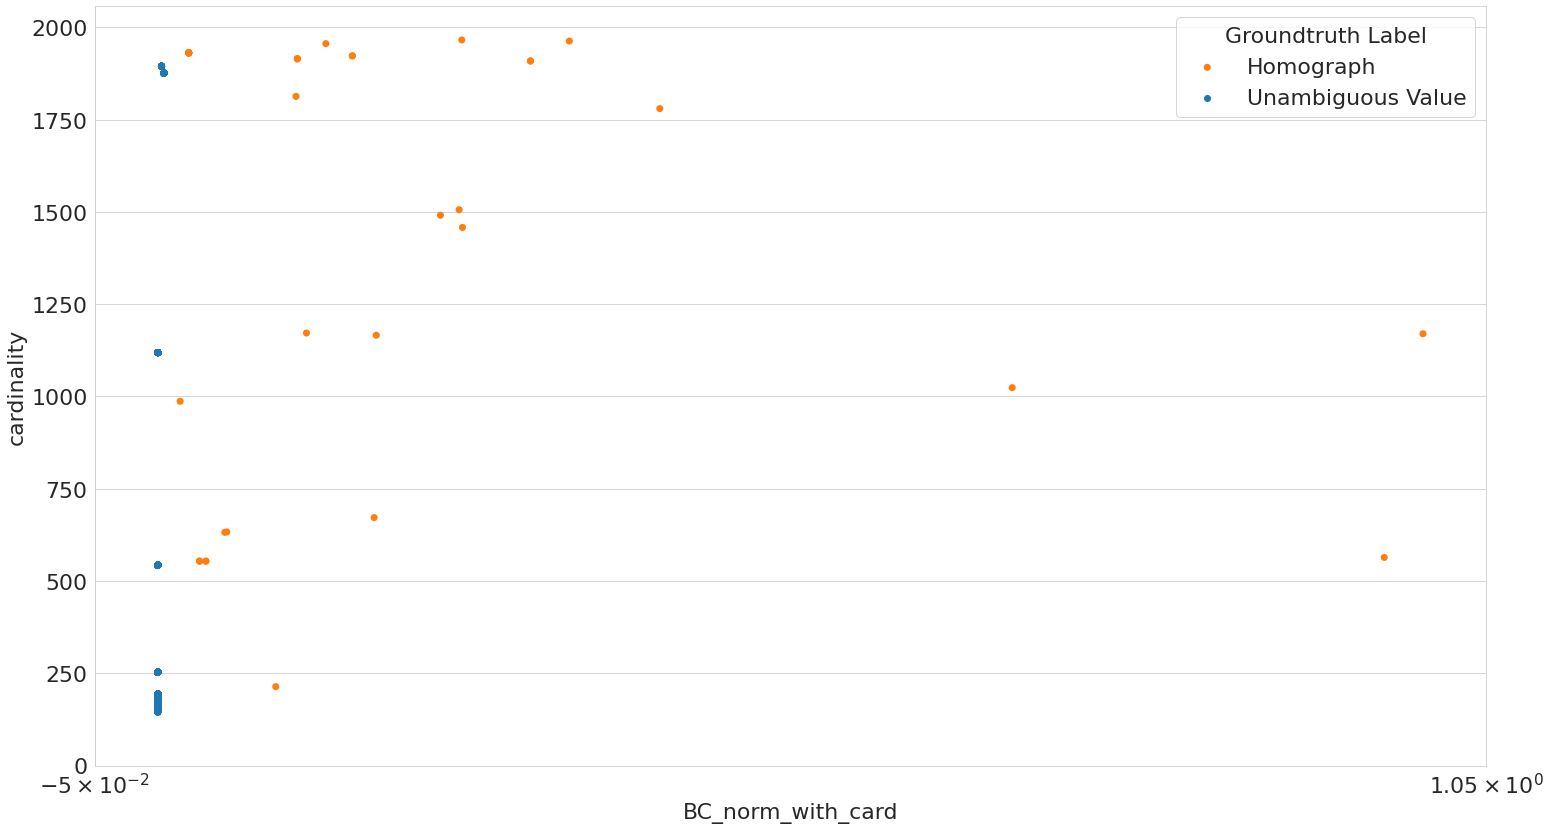

In [215]:
ax = sns.scatterplot(data=df_sb, x="BC_norm_with_card", y="cardinality", hue="is_homograph", linewidth=0, s=50)
ax.set(xlabel='BC_norm_with_card', xscale='log', ylim=(0, None))
plt.legend(title='Groundtruth Label', labels=['Homograph', 'Unambiguous Value'])
plt.xscale('symlog')
plt.tight_layout()
# plt.savefig('figures/centrality_analysis/sb_BC_vs_cardinality.svg')

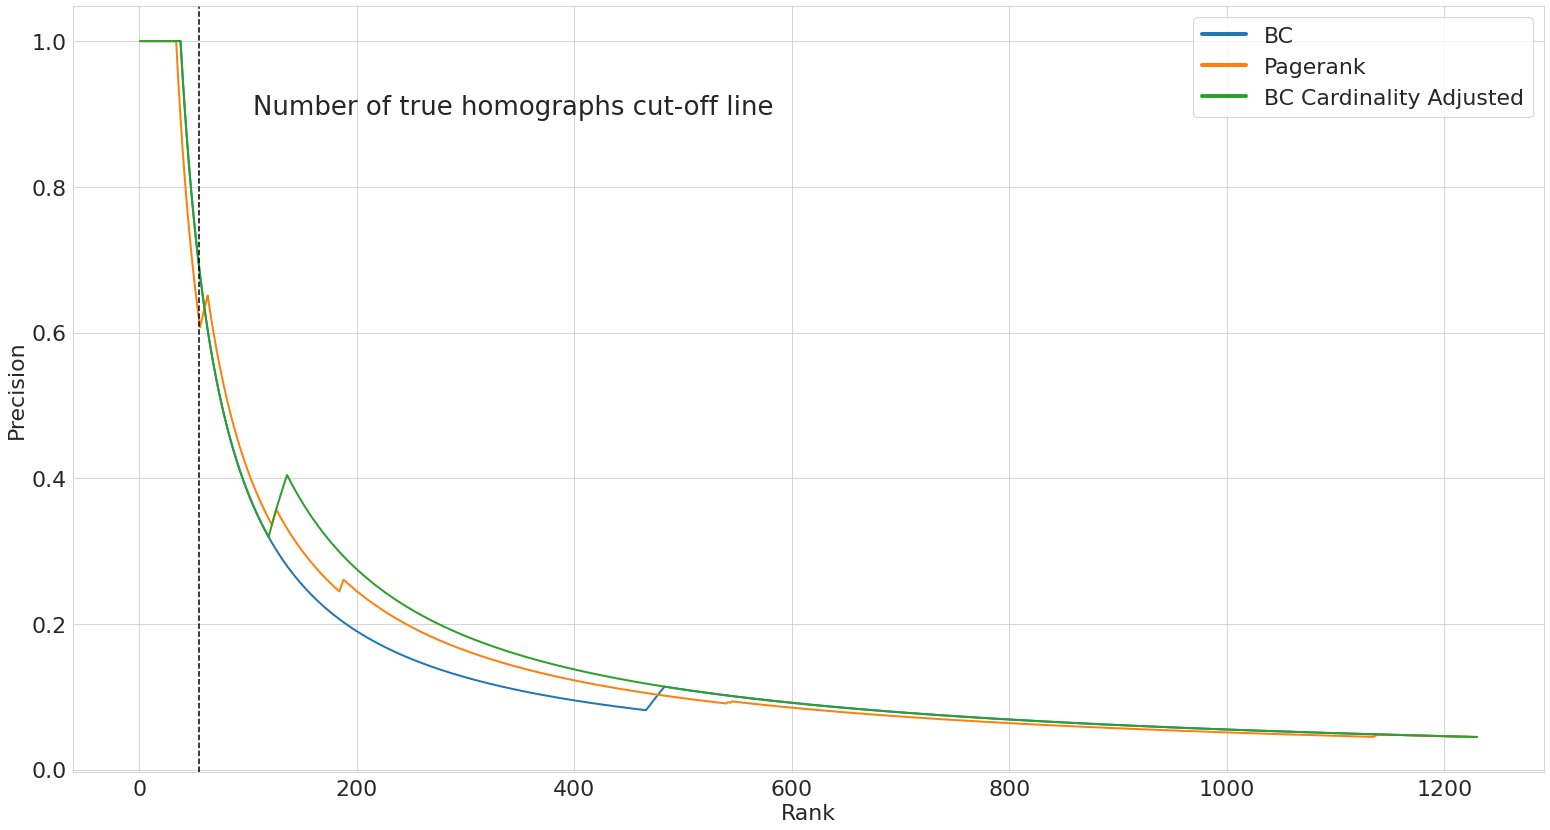

In [220]:
# Precision
k = df_sb.shape[0]
ranks = list(range(1, k+1))

measure_names = ['BC', 'Pagerank', 'BC Cardinality Adjusted']
measures = ['betweenness_centrality', 'pagerank', 'BC_norm_with_card']
for (measure, measure_name) in zip(measures, measure_names):
    plt.plot(ranks, df_sb.sort_values(by=[measure+'_rank'])[measure+'_precision'].values[0:k], label=measure_name, linewidth=2)

plt.axvline(x=num_true_homographs, color='black', linestyle='--')
plt.text(num_true_homographs + 50, 0.90,'Number of true homographs cut-off line', fontsize=26)

plt.xlabel('Rank')
plt.ylabel('Precision')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig('figures/centrality_analysis/sb_precision.svg')

In [129]:
attrs = utils.graph_helpers.get_attribute_of_instance(g_sb, 'Ram')
print(attrs)
vals1 = set(utils.graph_helpers.get_instances_for_attribute(g_sb, attrs[0]))
vals2 = set(utils.graph_helpers.get_instances_for_attribute(g_sb, attrs[1]))

print("Intersection size:", len(vals1 & vals2))
print("Union size:", len(vals1 | vals2))

['car_make_product_car_make_car_model_car_model_year_country_code.csv', 'car_model_product_car_make_car_model_car_model_year_country_code.csv']
Intersection size: 1
Union size: 564


In [69]:
print(g_sb['GA'])

{'state_abbrev_location_state_state_abbrev.csv': {}, 'country_code_product_movie_title_movie_genre_country_code.csv': {}}
